In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

plt.style.use('ggplot')
%matplotlib inline

# dipole_moments = pd.read_csv("../input/dipole_moments.csv")
# magnetic_shielding_tensors = pd.read_csv("../input/magnetic_shielding_tensors.csv")
# mulliken_charges = pd.read_csv("../input/mulliken_charges.csv")
# potential_energy = pd.read_csv("../input/potential_energy.csv")
# scalar_coupling_contributions = pd.read_csv("../input/scalar_coupling_contributions.csv")

In [ ]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

Let's start by doing a simple analysis of the data.

In [42]:
train.sample(3)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
3190761,3190761,dsgdb9nsd_092746,15,5,3JHC,8.01552
1798762,1798762,dsgdb9nsd_058286,12,4,3JHC,3.07635
4542294,4542294,dsgdb9nsd_126746,15,5,2JHC,28.51080


The training has an id for each row, the name of the molecule where the coupling constant originates (the corresponding XYZ file is located at ./structures/.xyz).`atom_index_0` and `atom_index_1` is the atom indices of the atom-pair creating the coupling. `type` is the type of the coupling and `scalar_coupling_constant` is the scalar coupling constant that we want to be able to predict.

In [ ]:
test.sample(3)

The test set structure is the same as the training except that we don't have the `scalar_coupling_constant` column. Among the other datasets, the most promising seems to be structures.csv, as it is the only one that is available for both training and testing sets. All the other dataframes are available only for the former.

In [ ]:
structures = pd.read_csv("../input/structures.csv")
structures.sample(3)

In [ ]:
molecule_1 = structures.iloc[:5,:]
molecule_1

In [ ]:
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

The first molecule is methane (CH4). Let's check its structure using plotly.

In [ ]:
trace1 = go.Scatter3d(
    x=molecule_1.x,
    y=molecule_1.y,
    z=molecule_1.z,
    mode='markers',
    marker=dict(
        size=10,
        color='rgb(255,0,0)',                # set color to an array/list of desired values      
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    )
    
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Well, that's pretty much what I expected from my high school chemistry classes. We could plot more molecule structures, but let's focus on other aspects of the data now. 

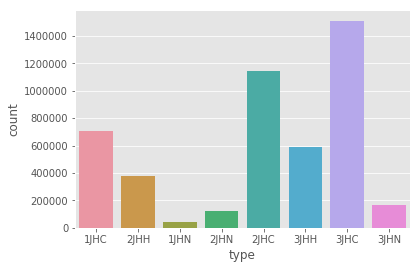

In [41]:
sb.countplot(train['type']);

There are some couplings that are more usual than others. 3JHC and 2JHC are the most common, followed by 1JHC. Couplings between Hydrogen and Nitrogen atoms are less frequent. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



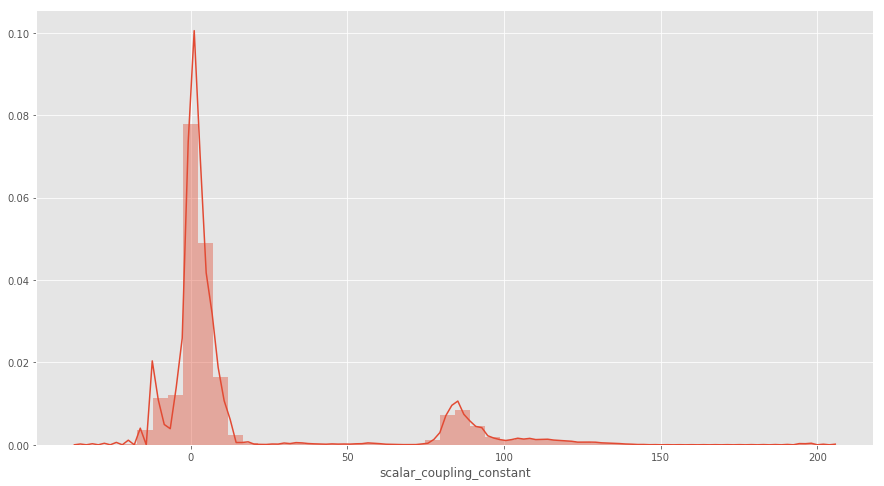

In [46]:
plt.figure(figsize = (15,8))
sb.distplot(train.scalar_coupling_constant);

We see two clearly different distributions of coupling constants. One around 0 and one around 80. What could be different?

In [63]:
scalar_abv_sixty = train[train.scalar_coupling_constant > 60]
scalar_abv_sixty.sample(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
3739838,3739838,dsgdb9nsd_106815,14,3,1JHC,87.8931
1762832,1762832,dsgdb9nsd_057402,21,6,1JHC,84.9877
4530124,4530124,dsgdb9nsd_126369,9,0,1JHC,88.3449
3039571,3039571,dsgdb9nsd_089286,14,2,1JHC,89.9151
2171934,2171934,dsgdb9nsd_067655,11,0,1JHC,85.5520


By selecting a random sample of 5 rows, they have their type in common. Is this a general rule?

In [64]:
scalar_abv_sixty.type.unique()

array(['1JHC', '1JHN', '3JHC'], dtype=object)

Actually this is not general, as there are 1JHN and 3JHC as well (but no 2JHC). Let's check the distribution.

In [65]:
scalar_abv_sixty.type.value_counts()

1JHC    709416
1JHN      5505
3JHC        16
Name: type, dtype: int64

Several 1JHC are in this group, with a small set of 1JHN and 3JHC. It is worth checking the number of each type in the whole training set.

In [58]:
train.type.value_counts()

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64

That's interesting. ALL 1JHC couplings are above 60. This must be good to leverage in our predictive models. Just a really small number of 3JHC are above this threshold, so this is extremely rare for this type of coupling. Perhaps this will turn out to be a good feature to use in our models.